In [2]:
from pycoral.utils import edgetpu
from pycoral.adapters import common
from PIL import Image
import numpy as np
import time
import os 
import re
import glob 
import tensorflow as tf

In [ ]:
import matplotlib.pyplot as plt

def visualize(original, augmented, figure_size=(10,5)):
    fig = plt.figure(figsize=figure_size)
    plt.subplot(1,2,1)
    plt.title('Original image')
    plt.imshow(original)
    plt.axis("off")

    plt.subplot(1,2,2)
    plt.title('Augmented image')
    plt.imshow(augmented)
    plt.axis("off")

In [ ]:
model_path = "/app/seg/jaccard_edgetpu_model_edgetpu.tflite"
interpreter = edgetpu.make_interpreter(model_path)
interpreter.allocate_tensors()
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [ ]:
input_details

In [ ]:
output_details

In [7]:
input_scale, input_zero_point = input_details[0]['quantization']
output_scale, output_zero_point = output_details[0]['quantization']

0.003668098943307996

In [10]:
def prepare_input_img(img_path, img_w=128, img_h=128):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_image(img, channels=3, dtype=tf.float32)
    resize_img = tf.image.resize_with_pad(img, target_height=img_h, target_width=img_w, method='bilinear')
    input_img = tf.expand_dims(resize_img, axis=0)
    return input_img

In [12]:
img_path = "/app/seg/data/images/train/9300633988715_1708724399603_0_1708724400676_1464882.jpg"
input_img = prepare_input_img(img_path)
input_img

<tf.Tensor: shape=(1, 128, 128, 3), dtype=float32, numpy=
array([[[[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        ...,

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]]]], dty

In [15]:
def quantized_input(input_tensor, input_scale, input_zero_point):
    return tf.cast((input_tensor / input_scale + input_zero_point), tf.uint8)

In [16]:
quantized_input = quantized_input(input_img, input_scale, input_zero_point)

<tf.Tensor: shape=(1, 128, 128, 3), dtype=uint8, numpy=
array([[[[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],

        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],

        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],

        ...,

        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],

        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],

        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]]]], dtype=uint8)>

In [18]:
interpreter.set_tensor(input_details[0]['index'], quantized_input)
interpreter.invoke()

In [19]:
def dequantized_output(output_tensor, output_scale, output_zero_point):
    return tf.cast(((output_tensor - output_zero_point) * output_scale), tf.float32)

In [21]:
output_data = interpreter.get_tensor(output_details[0]['index'])
deq_output = dequantized_output(output_data, output_scale, output_zero_point)
deq_output.shape

TensorShape([1, 128, 128, 1])

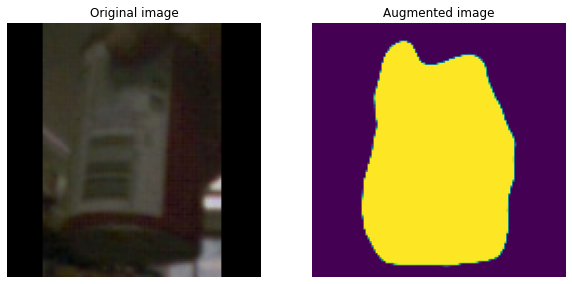

In [22]:
visualize(tf.squeeze(input_img), tf.squeeze(deq_output))

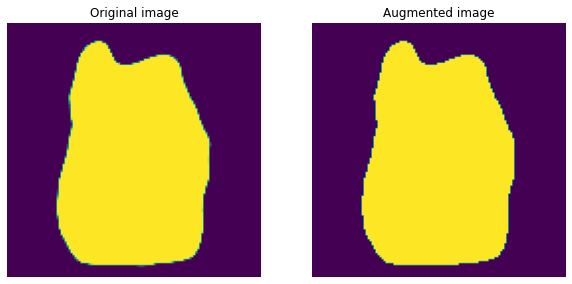

In [25]:
dqoutput = tf.squeeze(deq_output)
mask = tf.where(dqoutput > 0.5, 1., 0)
visualize(dqoutput, mask)